# Preparing DTI to simulate Anisotropic Conductivity in Sim4Life

This tutorial demonstrates how to pre-process diffusion tensor images to use within Sim4Life to create conductivity tensor maps [[1]](#1), which can be assigned as material property in low-frequency electro-magnetic simulations.

The notebook uses data from the [IXI-dataset](https://brain-development.org/ixi-dataset/) and relies on third-party packages [SimpleITK](https://simpleitk.org/) and [dipy](https://dipy.org/) for pre-processing the input diffusion weighted images (DWI) and reconstructing the diffusion tensor image (DTI). These pre-processing steps have been packaged in a simple-to-install package s4l-dti.

The DWI is usually a 4D image, essentially a concatenation of 3D volumes, one per gradient direction. The important information about the gradient direction and gradient strength for each volume is stored in the .bvec/.bval files. The bvals contain a single number per volume that indicates how large of a diffusion gradient was applied to the data. The bvecs file contains the direction of the applied gradient for each volume.

## Setup Environment

In [1]:
import sys

py = sys.executable

!{py} -c "import s4l_dti" || {py} -m pip install -q s4l_dti
!{py} -c "import matplotlib" || {py} -m pip install -q matplotlib
%matplotlib inline

skip_denoise = True

## Preparing the DTI for Sim4Life

### Download Data

In [2]:
from pathlib import Path

from s4l_dti.data import download_ixi_025

download_dir = Path.home() / "Models" / "IXI025"
download_files = download_ixi_025(download_dir)

for key in download_files:
    print(f"Downloaded {key}: {download_files[key].relative_to(download_dir)}")

Downloaded dwi: dwi/IXI025-Guys-0852-DWI.nii.gz
Downloaded bvec: dwi/IXI025-Guys-0852-DWI.bvec
Downloaded bval: dwi/IXI025-Guys-0852-DWI.bval
Downloaded t1: anat/IXI025-Guys-0852-T1.nii.gz
Downloaded labels: seg/IXI025-Guys-0852-SEG.nii.gz


/Users/lloyd/Code/s4l-dti/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Register DWI to T1-Image

Now that we have downloaded some test data, lets register the diffusion weighted image (DWI) to the T1-weighted image, so it is aligned with the segmentation. This step is often necessary due to distortions caused by Eddy-currents and/or movement of the subject during scanning.

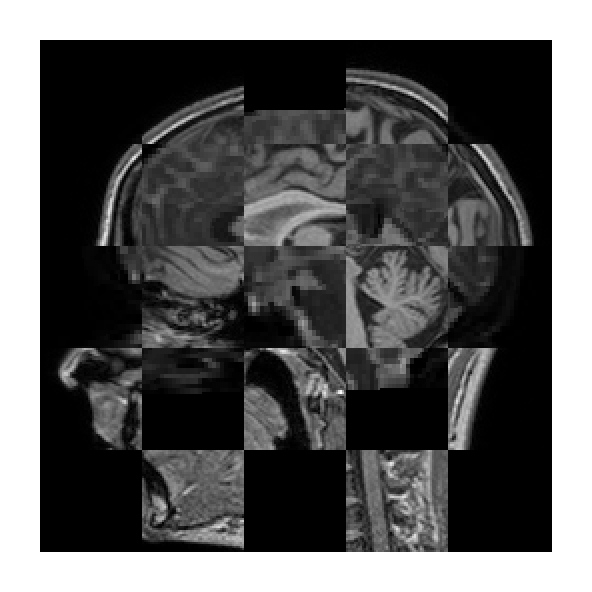

In [7]:
import SimpleITK as sitk

from s4l_dti.imshow import plot
from s4l_dti.register import (
    RegistrationMetric,
    Transform,
    apply_transform_header,
    extract_channel,
    register,
    resample_to,
)


t1_image_file = download_files["t1"]
dwi_image_file = download_files["dwi"]

dwi_image = sitk.ReadImage(dwi_image_file, sitk.sitkVectorFloat32)
t1_image = sitk.ReadImage(t1_image_file, sitk.sitkFloat32)

# Extract (3D) component 0 from (4D) DWI image
# - registration requires fixed image to have dimension as moving image
dwi_image0 = extract_channel(dwi_image)

# Find transform that aligns moving to fixed image
tx = register(
    moving_image=dwi_image0,
    fixed_image=t1_image,
    dof=Transform.euler,
    metric=RegistrationMetric.mattes,
)
transformed_dwi_image = apply_transform_header(dwi_image, tx)

# Save this aligned DWI in the download directory
dwi_aligned_image_file = download_dir / dwi_image_file.name.replace(
    ".nii.gz", "-aligned.nii.gz"
)
sitk.WriteImage(transformed_dwi_image, dwi_aligned_image_file)

plot(
    sitk.CheckerBoard(
        resample_to(sitk.RescaleIntensity(dwi_image0), t1_image),
        sitk.RescaleIntensity(t1_image),
        [5, 5, 5],
    )[:, ::-1],
    dpi=400,
    factor=2,
)

### Remove Noise in DWI

Diffusion-weighted images are often noisy. To remove some of the noise various techniques can be used. The helper library `s4l-dti` wraps the Marcenko-Pastur PCA technique implemented in `dipy`. For alternatives, please refer to the dipy documentation: https://workshop.dipy.org/documentation/1.7.0/interfaces/denoise_flow/

In [8]:
from s4l_dti.denoise import denoise_mppca

if not skip_denoise:
    dwi_aligned_denoised_image_file = (
        download_dir
        / dwi_aligned_image_file.name.replace(".nii.gz", "-denoised.nii.gz")
    )
    denoise_mppca(dwi_aligned_image_file, dwi_aligned_denoised_image_file)

else:
    dwi_aligned_denoised_image_file = dwi_aligned_image_file

### Reconstruct Diffusion Tensor Image from DWI

Finally, we need to reconstruct the DTI from the DWI, bvecs and bvals. The DTI is saved in a format compatible with Sim4Life: 
- since the diffusion tensors are symmetric, only the lower 6 components are needed
- Sim4Life expects the components in the order: XX, YY, ZZ, XY, YZ, ZX

In [9]:
from s4l_dti.reconstruct import reconstruct_dti as reconstruct_dti

bvec_file = download_files["bvec"]
bval_file = download_files["bval"]
mask_file = download_files["labels"]
s4l_dti_file = download_dir / bvec_file.name.replace("DWI.bvec", "DTI-s4l.nii.gz")

reconstruct_dti(
    img_file=dwi_aligned_denoised_image_file,
    bvec_file=bvec_file,
    bval_file=bval_file,
    s4l_dti_file=s4l_dti_file,
    # mask_file=mask_file
)

## References
<a id="1">[1]</a> 
Tuch, David S., et al. Conductivity tensor mapping of the human brain using diffusion tensor MRI. Proceedings of the National Academy of Sciences 98.20 (2001): 11697-11701.